# EDA FOR UNIVARIATE TIME SERIES

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
import itertools
import numpy as np
import datetime

import calendar
import os
import random
import statsmodels.api as sm

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
# In order to use this notebook for univarate time series analysis :-
# 1) The primary requirement is not to have missing values or categorial(string) data for time_dependent variable 
#    and time_column.
# 2) This cell requires information on file_name (only csv), time_dependent_variable, time_column, date_time format (frmt)
#    and resample grain(X). After filling the required information correctly, you can run all the cells (Cell ---> Run All)
# 3) Example :-
#   file_name               = "JetRail Avg Hourly Traffic Data - 2012-2013.csv"
#   time_dependent_variable = "Count"    (column name in your dataset)
#   time_column             = "Datetime" (column name in your dataset)
#   frmt                    = "%Y-%m-%d"
#   X                       = "D" 

file_name = "JetRail Avg Hourly Traffic Data - 2012-2013.csv"
time_dependent_variable = "Count"
time_column = "Datetime"
frmt =  "%Y-%m-%d"
X = "D"

### Read the dataset

In [20]:
def data(time_column, file_name, frmt='%Y-%m-%d %H:%M:%S', X= "D"):
    df = pd.read_csv(file_name, parse_dates= True)
    df = df[[time_column,time_dependent_variable]]
    df[time_column] = pd.to_datetime(df[time_column],format=frmt) 
    df.index = df[time_column]
    df = df.resample(X).mean()
    df.reset_index(inplace= True)
    return df
df = data(time_column, file_name, frmt,X )

In [21]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Missing(% of Total values)']= (100 * summary['Missing']) / df.shape[0]
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    return summary
resumetable(df)

Dataset Shape: (494, 2)


,Name,dtypes,Missing,Missing(% of Total values),Uniques,First Value,Second Value
0,Datetime,datetime64[ns],0,0.0,494,2012-08-25 00:00:00,2012-08-26 00:00:00
1,Count,float64,0,0.0,415,3.166667,3.666667


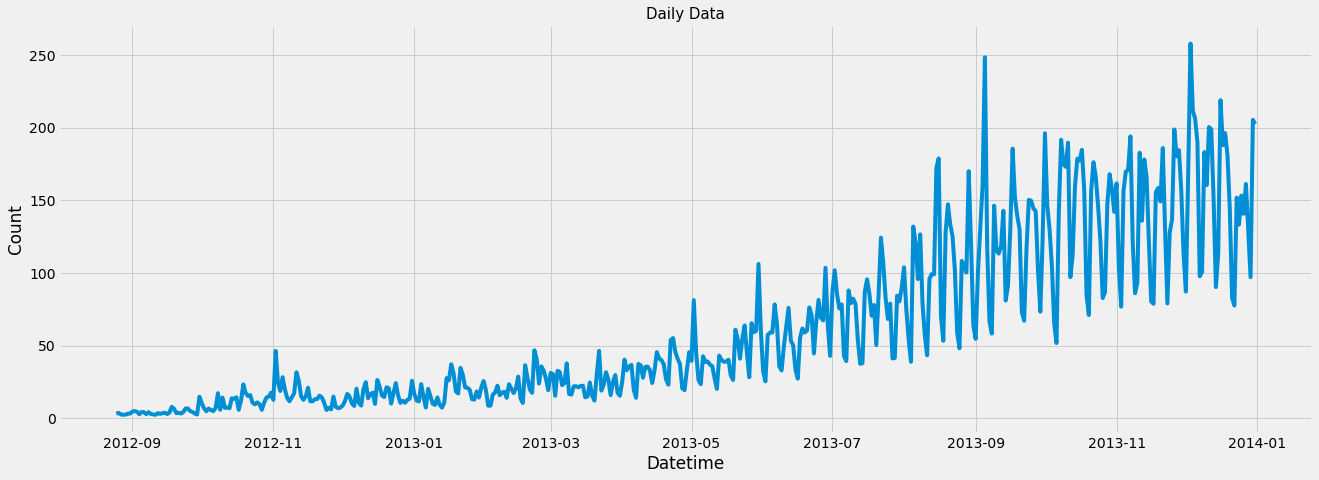

In [5]:
## Plot the Time series data
def graph(time_column, time_dependent_variable):
    global df
    fig, ax = plt.subplots(figsize=(20,7))
    a = sns.lineplot(x=time_column, y=time_dependent_variable, data=df)
    a.set_title("Daily Data",fontsize=15)
    plt.show()
graph(time_column, time_dependent_variable)

# Exploratory Data Analysis

Creates time series features from Date column.

In [6]:
def date_features(df, time_column, time_dependent_variable):
    df = df.copy()

    
    df['month'] = df[time_column].dt.strftime('%B')
    df['year'] = df[time_column].dt.strftime('%Y')
    df['dayofweek'] = df[time_column].dt.strftime('%A')
    df['quarter'] = df[time_column].dt.quarter
    df['dayofyear'] = df[time_column].dt.dayofyear
    df['dayofmonth'] = df[time_column].dt.day
    df['weekofyear'] = df[time_column].dt.weekofyear
    

    return df
df_new = date_features(df, time_column, time_dependent_variable)

df_new.head()

,Datetime,ID,Count,month,year,dayofweek,quarter,dayofyear,dayofmonth,weekofyear
0,2012-08-25,11.5,3.166667,August,2012,Saturday,3,238,25,34
1,2012-08-26,35.5,3.666667,August,2012,Sunday,3,239,26,34
2,2012-08-27,59.5,2.583333,August,2012,Monday,3,240,27,35
3,2012-08-28,83.5,2.416667,August,2012,Tuesday,3,241,28,35
4,2012-08-29,107.5,2.500000,August,2012,Wednesday,3,242,29,35


## Plotting the Features to see trends

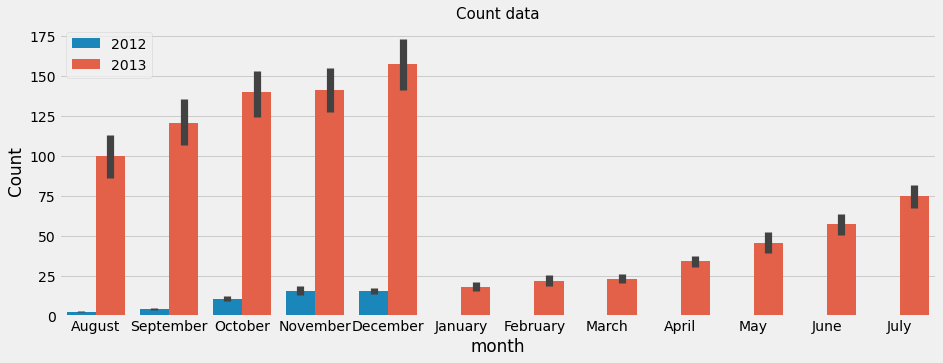

In [7]:
def eda(time_column, time_dependent_variable):
    fig, ax = plt.subplots(figsize=(14,5))
    palette = sns.color_palette("mako_r", 4)
    a = sns.barplot(x="month", y=time_dependent_variable, hue = 'year',data=df_new)
    a.set_title(time_dependent_variable+" "+ "data",fontsize=15)
    plt.legend(loc="best")
    plt.show()
eda(time_column, time_dependent_variable)

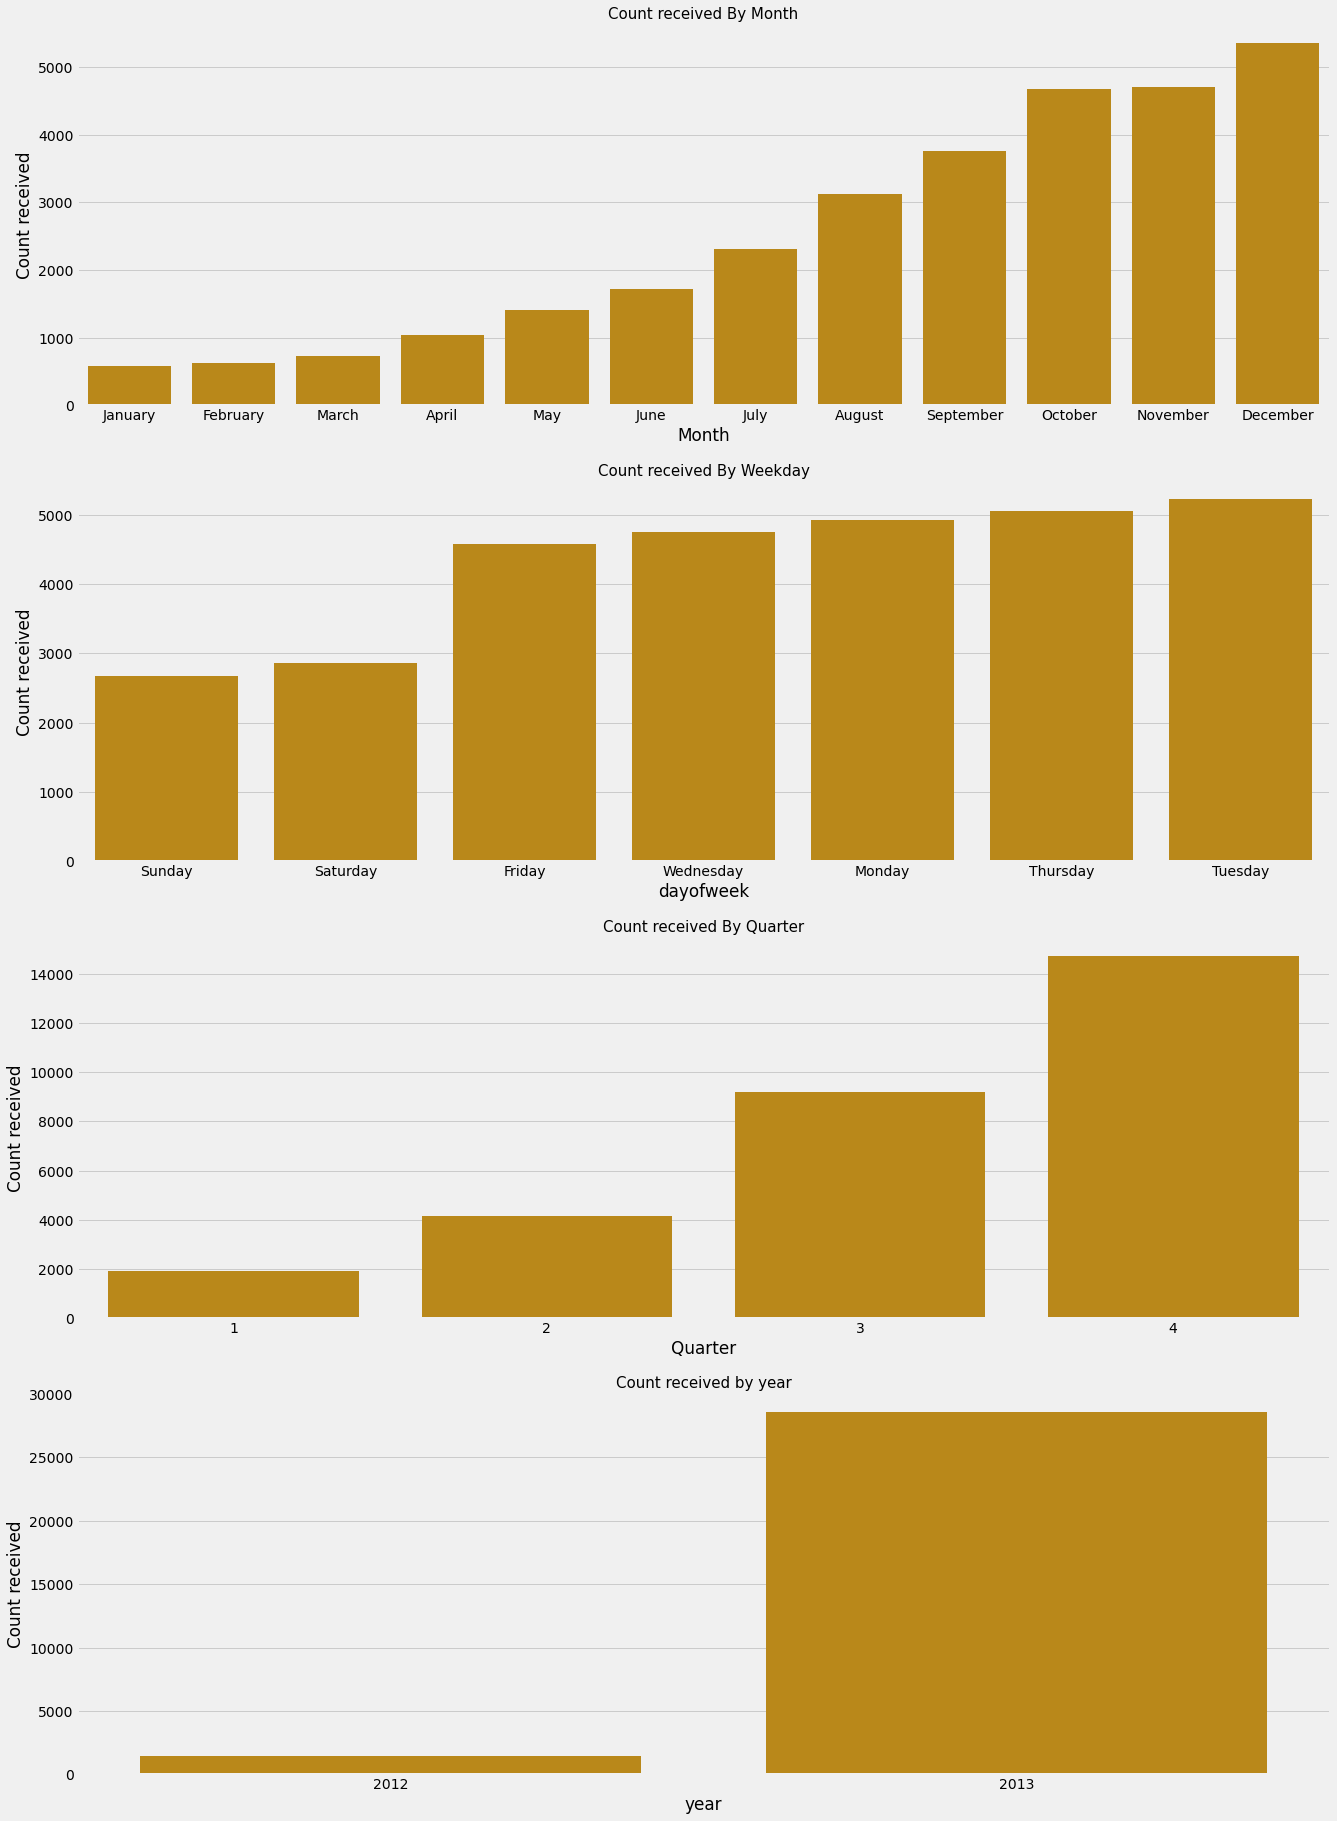

In [8]:
 def metadata_eda(time_dependent_variable, rotation= 0 ,color = "#D39200"):  
    fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
    fig.set_size_inches(20,30)
    plt.xticks(rotation=rotation)
    

    monthAggregated = pd.DataFrame(df_new.groupby("month")[time_dependent_variable].sum()).reset_index().sort_values(time_dependent_variable)
    sns.barplot(data=monthAggregated,x="month",y=time_dependent_variable,ax=ax1,   color = color)
    ax1.set(xlabel='Month', ylabel= time_dependent_variable+" " + "received")
    ax1.set_title(time_dependent_variable+" " + "received By Month",fontsize=15)

    monthAggregated = pd.DataFrame(df_new.groupby("dayofweek")[time_dependent_variable].sum()).reset_index().sort_values(time_dependent_variable)
    sns.barplot(data=monthAggregated,x="dayofweek",y=time_dependent_variable,ax=ax2, color = color)
    ax2.set(xlabel='dayofweek', ylabel= time_dependent_variable+" " + "received")
    ax2.set_title(time_dependent_variable+" " + "received By Weekday",fontsize=15)

    monthAggregated = pd.DataFrame(df_new.groupby("quarter")[time_dependent_variable].sum()).reset_index().sort_values(time_dependent_variable)
    sns.barplot(data=monthAggregated,x="quarter",y=time_dependent_variable,ax=ax3, color = color)
    ax3.set(xlabel='Quarter', ylabel= time_dependent_variable+" " + "received")
    ax3.set_title(time_dependent_variable+" " + "received By Quarter",fontsize=15)

    monthAggregated = pd.DataFrame(df_new.groupby("year")[time_dependent_variable].sum()).reset_index().sort_values(time_dependent_variable)
    sns.barplot(data=monthAggregated,x="year",y=time_dependent_variable,ax=ax4, color = color)
    ax4.set(xlabel='year', ylabel= time_dependent_variable+" " + "received")
    ax4.set_title(time_dependent_variable+" " + "received by year",fontsize=15)
metadata_eda(time_dependent_variable)

In [9]:
df.head()

,Datetime,ID,Count
0,2012-08-25,11.5,3.166667
1,2012-08-26,35.5,3.666667
2,2012-08-27,59.5,2.583333
3,2012-08-28,83.5,2.416667
4,2012-08-29,107.5,2.500000


# Pattern with Metadata

### Exploring quarterly pattern if any:

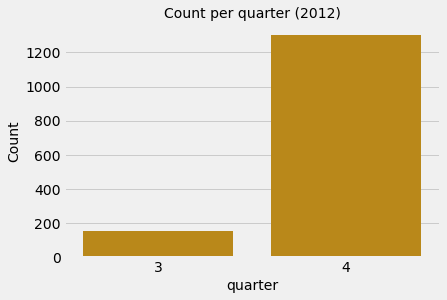

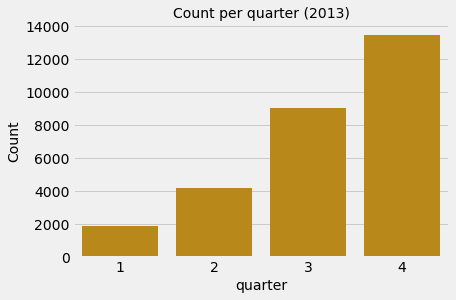

In [10]:
def quarterly_pattern_over_years(time_column, time_dependent_variable, rotation=0, color = "#D39200"): 
    for year in df[time_column].dt.year.unique():
        #Filtering data for specific year
        x = df[df[time_column].dt.year == year]

        #Extracting month name from date
        x['quarter']=x[time_column].dt.quarter

        #Grouping data by months and adding time_dependent_variable
        x=x.groupby(['quarter'], as_index=False).agg({time_dependent_variable:'sum'})



        #Plotting month Vs time_dependent_variablefor every year
        #plt.figure(figsize=(12,8))
        sns.barplot(x = x.quarter, y = time_dependent_variable, data = x, order= x.sort_values(time_dependent_variable).quarter, color = color)
        plt.xticks(rotation=rotation)
        plt.title(time_dependent_variable +" " + "per quarter ("+str(year)+")",fontsize=14)
        plt.ylabel(time_dependent_variable, fontsize=14)
        plt.xlabel('quarter',fontsize=14)
        plt.show()
        del x
quarterly_pattern_over_years(time_column, time_dependent_variable )

### Exploring montly pattern if any:

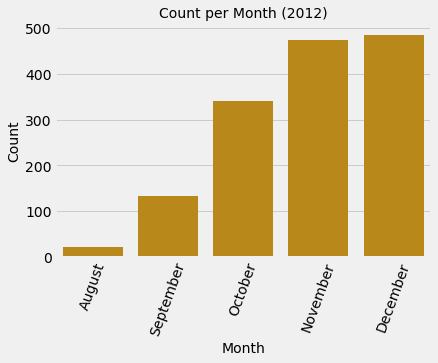

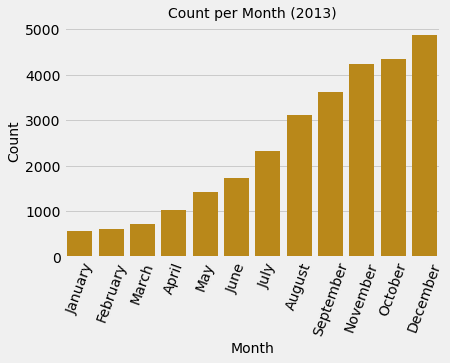

In [11]:
 def montly_pattern_over_years(time_column, time_dependent_variable, rotation=70, color = "#D39200"): 
    for year in df[time_column].dt.year.unique():
        #Filtering data for specific year
        x = df[df[time_column].dt.year == year]

        #Extracting month name from date
        x['month']=x[time_column].dt.month_name()

        #Grouping data by months and adding time_dependent_variable
        x=x.groupby(['month'], as_index=False).agg({time_dependent_variable:'sum'})



        #Plotting month Vs time_dependent_variable for every year
        #plt.figure(figsize=(12,8))
        sns.barplot(x = x.month, y = time_dependent_variable, data = x, order= x.sort_values(time_dependent_variable).month, color = color)
        plt.xticks(rotation=rotation)
        plt.title(time_dependent_variable +" " + "per Month ("+str(year)+")",fontsize=14)
        plt.ylabel(time_dependent_variable, fontsize=14)
        plt.xlabel('Month',fontsize=14)
        plt.show()
        del x
montly_pattern_over_years(time_column, time_dependent_variable)

### Exploring weekly pattern if any:

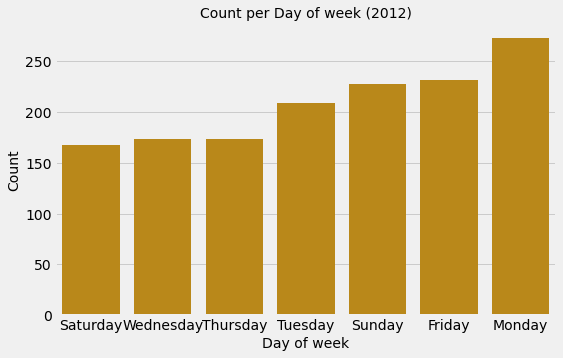

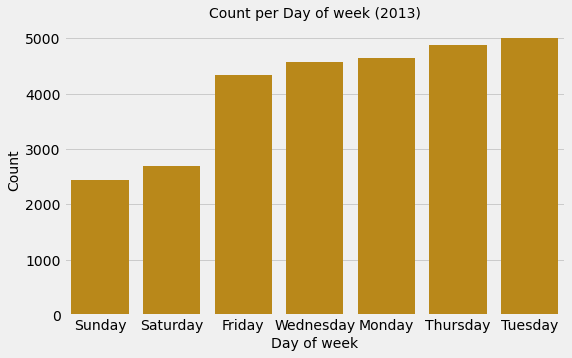

In [12]:
def weekly_pattern_over_years(time_column, time_dependent_variable , rotation=70, color = "#D39200"):
    for year in df[time_column].dt.year.unique():
        
        #Filtering data for specific year
        x = df[df[time_column].dt.year == year]

        #Adding Day of Week as a Feature
        x['day_of_week'] = x[time_column].dt.day_name()
        
        # Group By day_of_week and Sum of time_dependent_variable for each day_of_week
        x = x.groupby(['day_of_week'], as_index=False).agg({time_dependent_variable:'sum'})


        #Plotting day_of_week Vs time_dependent_variable
        plt.figure(figsize=(8,5))
        sns.barplot(x = x.day_of_week, y = time_dependent_variable, data = x, order= x.sort_values(time_dependent_variable).day_of_week, color = color)
        plt.title(time_dependent_variable+" "+ "per Day of week ("+str(year)+")", fontsize= 14)
        plt.xlabel('Day of week', fontsize= 14)
        plt.ylabel(time_dependent_variable, fontsize= 14)

        del x
weekly_pattern_over_years(time_column, time_dependent_variable)

## EDA of the Variable to be Forecasted (time_dependent_variable)

In [13]:
df.set_index(time_column, inplace= True)
df.head()

,ID,Count
Datetime,,
2012-08-25,11.5,3.166667
2012-08-26,35.5,3.666667
2012-08-27,59.5,2.583333
2012-08-28,83.5,2.416667
2012-08-29,107.5,2.500000


In [14]:
#Set up plot functions
def plt_( time_dependent_variable, dataset= df):    
    plt.figure(figsize=(12,6))
    plt.plot(dataset[time_dependent_variable], color = 'b')
    plt.show()
    
def density_plt_(time_dependent_variable, dataset= df ):
    plt.figure(figsize=(12,6))
    sns.distplot(dataset[time_dependent_variable])
    plt.show()
    
#Decomposition
def decomp_plt_(time_dependent_variable, dataset= df ,freq = 7,  model='additive'):
    decomposition = seasonal_decompose(dataset[time_dependent_variable], freq = 12, model=model) #Can't handle missing data
    fig = plt.figure(figsize = (20, 10))
    ax = fig.add_subplot(411)
    ax.plot(dataset[time_dependent_variable], label='Original', color = 'b')
    ax.legend(loc='best')
    ax = fig.add_subplot(412)
    ax.plot(decomposition.trend, label='Trend', color = 'b')
    ax.legend(loc='best')
    ax = fig.add_subplot(413)
    ax.plot(decomposition.seasonal,label='Seasonality', color = 'b')
    ax.legend(loc='best')
    ax= fig.add_subplot(414)
    ax.plot(decomposition.resid, label='Residuals', color = 'b')
    ax.legend(loc='best')
    plt.show()

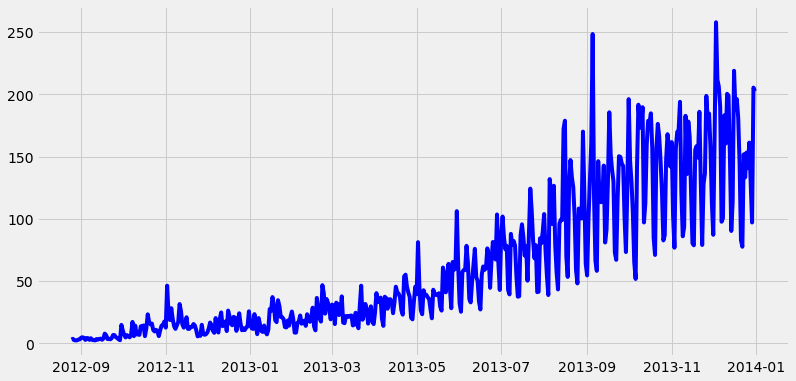

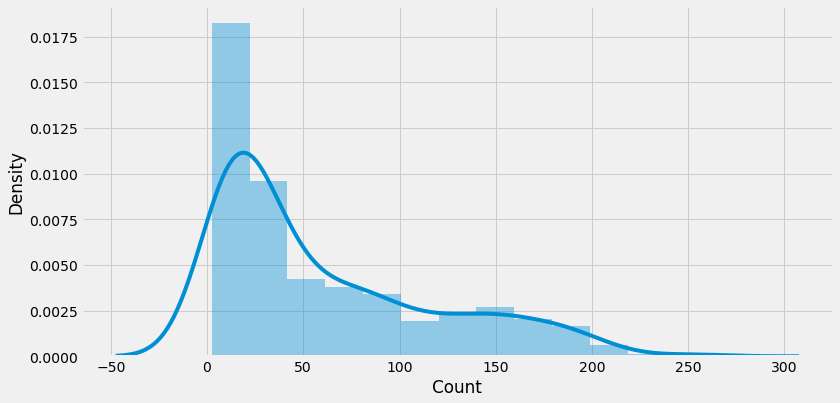

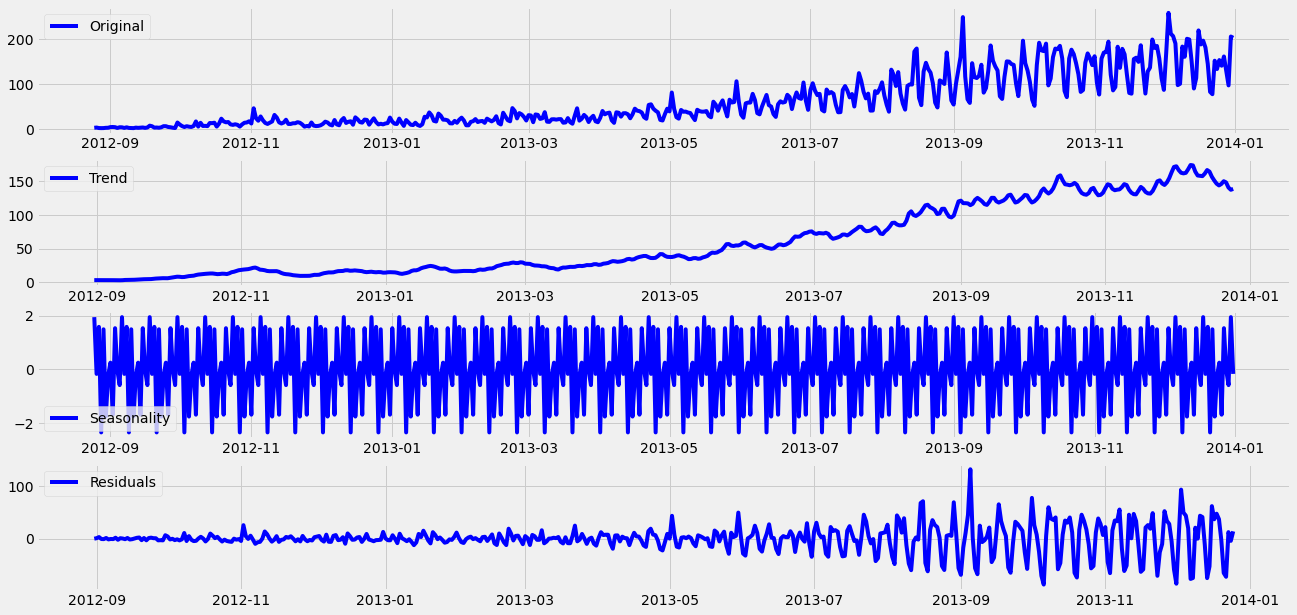

In [15]:
plt_( time_dependent_variable)
density_plt_( time_dependent_variable)
decomp_plt_( time_dependent_variable,df,freq = 7)

### Testing For Stationarity

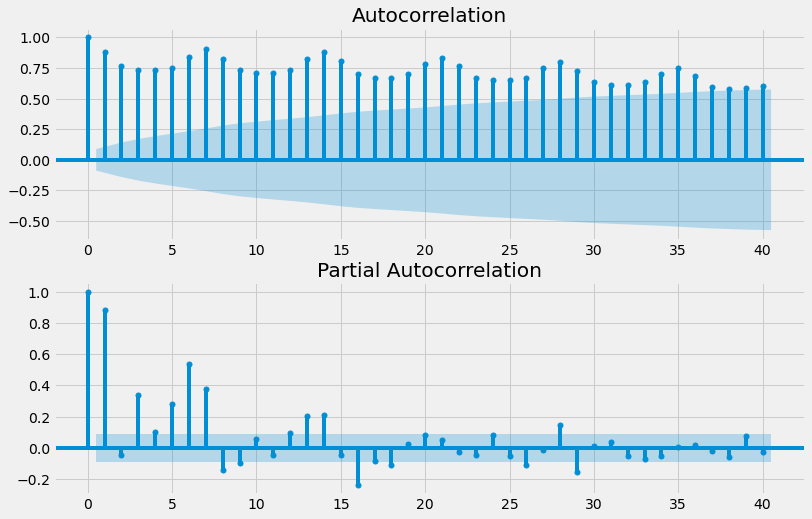

In [16]:
# ACF  -> It is a function that provides you with the information of how much a series is autocorrelated with its lagged values.
#         In simple terms, it describes how well the present value of the series is related with its past values.
# PACF -> It is another important function that finds correlation of the residuals with the next lag. It is a function that
#         measures the incremental benefit of adding another lag. So if through the PACF function we discover that there 
#         is hidden information in the residual that can be modeled by the next lag, we will keep that next lag as a feature 
#         while modeling.

def acf_pacf_plot(df, time_dependent_variable, lags=40):  
    import statsmodels.api as sm

    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(df[time_dependent_variable], lags=lags, ax=ax1) # 
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(df[time_dependent_variable], lags=lags, ax=ax2)# , lags=40
acf_pacf_plot(df, time_dependent_variable, lags=40)

### Augmented Dickey-Fuller test

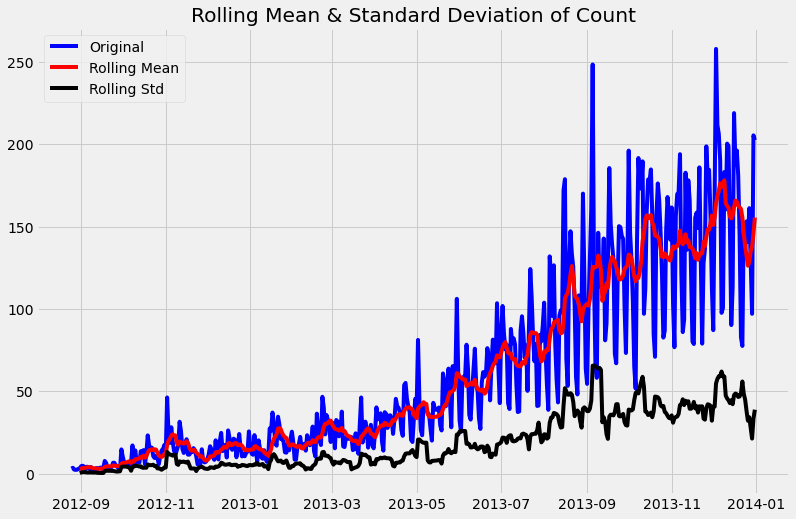

Results of Dickey-Fuller Test:
ADF Test Statistic : -1.4796067937601125
p-value : 0.8360104167646436
Lags Used : 27
Number of Observations Used : 466
Weak Evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [17]:
# The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate processin the presence of 
# serial correlation.

# Ho ---> It is non-stationary
# H1 ---> It is stationary

# Caveat : Can't handle missing data

from statsmodels.tsa.stattools import adfuller 

def test_stationarity(df, time_dependent_variable, window = 7, cutoff = 0.01, maxlag=30, regression="c",autolag= "AIC",store=False,regresults=False):

    #Determing rolling statistics
    rolmean = df[time_dependent_variable].rolling(window).mean()
    rolstd = df[time_dependent_variable].rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(df[time_dependent_variable], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation of '+ time_dependent_variable )
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    result=adfuller(df[time_dependent_variable],maxlag,regression,autolag,store,regresults)
    labels = ['ADF Test Statistic','p-value','Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= cutoff:
        print("Strong Evidence against the null hypothesis(Ho), reject the null hypothesis.\nData has no unit root and is stationary")
    else:
        print("Weak Evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
    
test_stationarity(df, time_dependent_variable, window = 7, cutoff = 0.01, maxlag=30, regression="ct",autolag= "AIC",store=False,regresults=False)

### Diffencing using Augmented Dickey-Fuller test

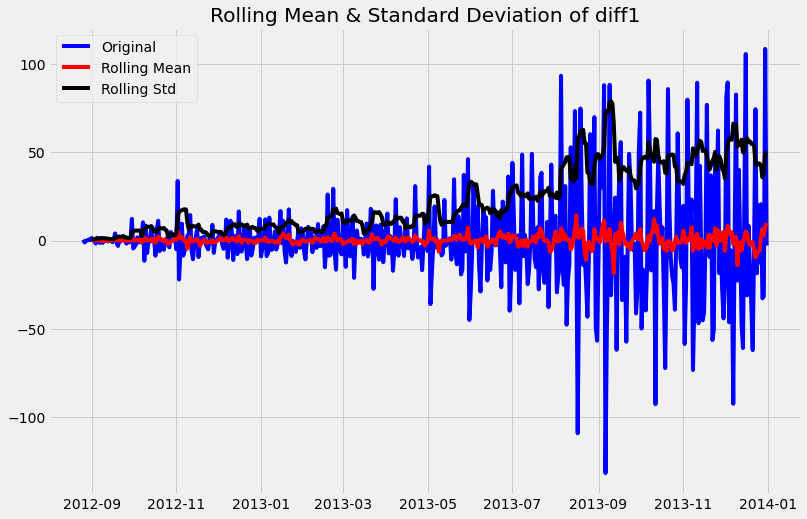

Results of Dickey-Fuller Test:
ADF Test Statistic : -7.900621220224721
p-value : 1.2127420208582466e-10
Lags Used : 26
Number of Observations Used : 466
Strong Evidence against the null hypothesis(Ho), reject the null hypothesis.
Data has no unit root and is stationary
Differencing_level : 1


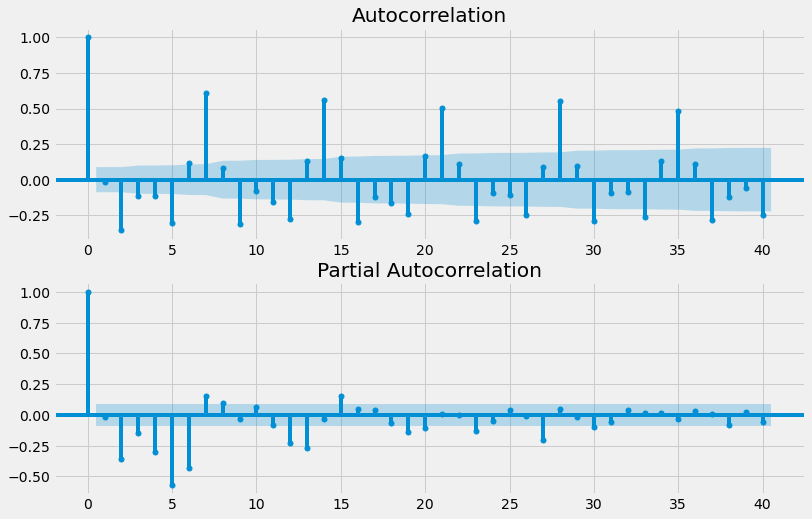

In [18]:
# Differencing the time series is one of widely used remedies for making the series stationary. The function below performs the 
# differencing based on the Augmented Dickey-Fuller test to make the time series stationary. In other words, it finds the
# smallest value of differencing level which makes the series stationary.


def differencing_series(df, time_dependent_variable, no_of_differences= 4, window = 7, cutoff = 0.01, maxlag=30, regression="ct",autolag= "AIC",store=False,regresults=False):
    for i in range( 1, no_of_differences):
        df["diff"+ str(i)] = df[time_dependent_variable] - df[time_dependent_variable].shift(i)
        df = df.dropna(inplace = False)
        #Perform Dickey-Fuller test:
        
        result=adfuller(df["diff"+ str(i)],maxlag,regression,autolag,store,regresults)

        if result[1] <= cutoff:
            test_stationarity(df, time_dependent_variable= "diff"+ str(i), window = window, cutoff = cutoff, maxlag=maxlag, regression=regression, autolag= autolag, store=False,regresults=False)
            print(("Differencing_level"+' : '+str(i)))
            fig = plt.figure(figsize=(12,8))
            ax1 = fig.add_subplot(211)
            fig = sm.graphics.tsa.plot_acf(df["diff"+ str(i)], lags=40, ax=ax1)
            ax2 = fig.add_subplot(212)
            fig = sm.graphics.tsa.plot_pacf(df["diff"+ str(i)], lags=40, ax=ax2)
            
            break
        else:
            test_stationarity(df, time_dependent_variable= "diff"+ str(i), window = window, cutoff = cutoff, maxlag=maxlag, regression=regression, autolag= autolag, store=False,regresults=False)

df_difference = df.copy()        
differencing_series(df_difference, time_dependent_variable, no_of_differences=4, window = 7, cutoff = 0.01, maxlag=30, regression="ct",autolag= "AIC",store=False,regresults=False)

### Seasonal Differencing

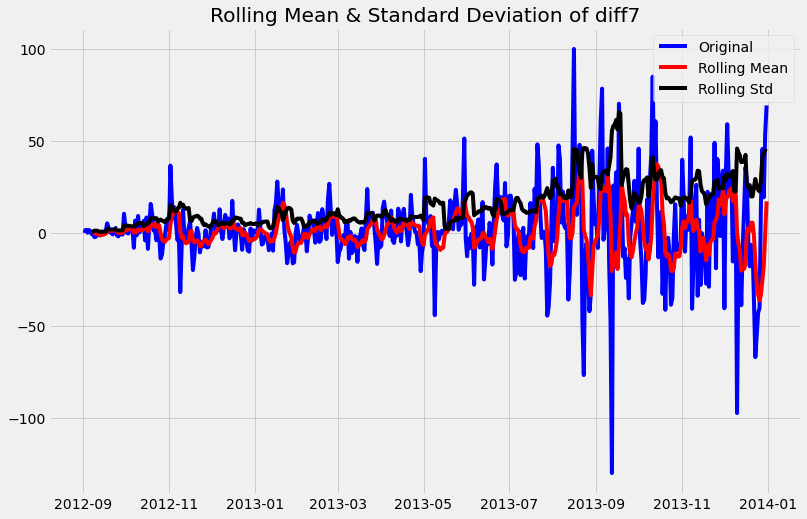

Results of Dickey-Fuller Test:
ADF Test Statistic : -6.720890138224322
p-value : 5.986602701179526e-08
Lags Used : 21
Number of Observations Used : 465
Strong Evidence against the null hypothesis(Ho), reject the null hypothesis.
Data has no unit root and is stationary
Differencing_level : 7


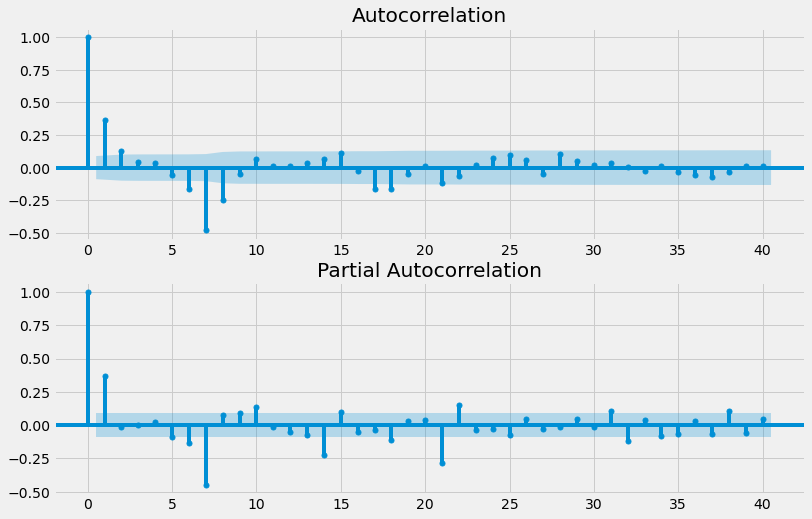

In [19]:
# The function below performs the seasonal differencing based on the Augmented Dickey-Fuller test 
# to make the time series stationary.

# A seasonal difference is the difference between an observation and the corresponding observation from a previous year.
# y'(t) = y(t) − y(t−m)

def seasonal_differencing_series(df, time_dependent_variable, m1,m2,m3,m4, window = 7, cutoff = 0.01, maxlag=30, regression="ct",autolag= "AIC",store=False,regresults=False):
    for i in [m1,m2,m3,m4]:
        df["diff"+ str(i)] = df[time_dependent_variable] - df[time_dependent_variable].shift(i)
        df = df.dropna(inplace = False)
        #Perform Dickey-Fuller test:
        
        result=adfuller(df["diff"+ str(i)],maxlag,regression,autolag,store,regresults)

        if result[1] <= cutoff:
            test_stationarity(df, time_dependent_variable= "diff"+ str(i), window = window, cutoff = cutoff, maxlag=maxlag, regression=regression, autolag= autolag, store=False,regresults=False)
            print(("Differencing_level"+' : '+str(i)))
            fig = plt.figure(figsize=(12,8))
            ax1 = fig.add_subplot(211)
            fig = sm.graphics.tsa.plot_acf(df["diff"+ str(i)], lags=40, ax=ax1)
            ax2 = fig.add_subplot(212)
            fig = sm.graphics.tsa.plot_pacf(df["diff"+ str(i)], lags=40, ax=ax2)
            
            break
        else:
            test_stationarity(df, time_dependent_variable= "diff"+ str(i), window = window, cutoff = cutoff, maxlag=maxlag, regression=regression, autolag= autolag, store=False,regresults=False)

        
seasonal_differencing_series(df, time_dependent_variable, m1=7,m2=14,m3=21,m4=28, window = 7, cutoff = 0.01, maxlag=30, regression="ct",autolag= "AIC",store=False,regresults=False)  